In [ ]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [ ]:
# Load the dataset
data = pd.read_excel('/content/sample_data/Telco_customer_churn.xlsx')

# Preview the dataset
print(data.head())
print(data.info())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [ ]:
data.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


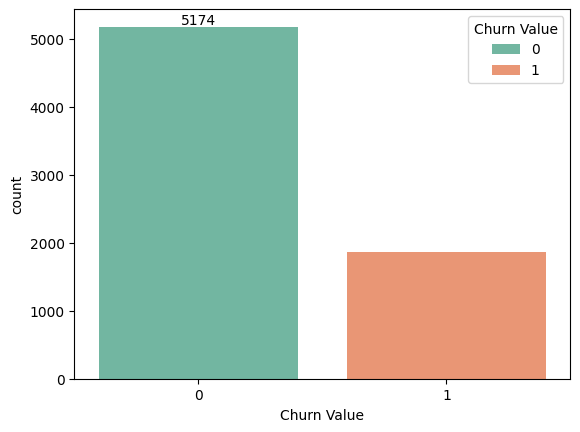

In [ ]:
ax = sns.countplot(data=data, x='Churn Value', hue='Churn Value', palette='Set2')
ax.bar_label(ax.containers[0])
plt.show()

# Preprocessing

In [ ]:
# inspect columns for missing data.
cols_na = [col for col in data.columns if data[col].isnull().sum() > 1]

for col in cols_na:
    print(f"{col}, {round(data[col].isnull().mean(), 4)} % Missing values")

Churn Reason, 0.7346 % Missing values


In [ ]:
# Look at rows with missing values
data[data[cols_na[0]].isnull()]

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
1869,7590-VHVEG,1,United States,California,Los Angeles,90001,"33.973616, -118.24902",33.973616,-118.249020,Female,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,27,3964,NaN
1870,5575-GNVDE,1,United States,California,Los Angeles,90002,"33.949255, -118.246978",33.949255,-118.246978,Male,...,One year,No,Mailed check,56.95,1889.5,No,0,61,3441,NaN
1871,7795-CFOCW,1,United States,California,Los Angeles,90004,"34.076259, -118.310715",34.076259,-118.310715,Male,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,66,4307,NaN
1872,1452-KIOVK,1,United States,California,Los Angeles,90007,"34.027337, -118.28515",34.027337,-118.285150,Male,...,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No,0,43,4459,NaN
1873,6713-OKOMC,1,United States,California,Los Angeles,90008,"34.008293, -118.346766",34.008293,-118.346766,Female,...,Month-to-month,No,Mailed check,29.75,301.9,No,0,51,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


In [ ]:
# Handling missing values
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')  # Convert TotalCharges to numeric

data.fillna({'Total Charges': data['Total Charges'].median()}, inplace=True)  # Fill missing values with median

# we are not actually going to use Churn Reason so don't worry about null values there.

# Drop rows without a value for target variable.
data.dropna(subset=['Churn Value'], inplace=True)

In [ ]:
# Drop all the target or related variables from the dataset for training.
x_drop_cols = ['Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason', 'CustomerID']
X = data.drop(x_drop_cols, axis=1)

# Split numerical and categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Categorical feature are: {categorical_features}")
print(f"Numerical feature are: {numerical_features}")

y = data['Churn Value']

X.info()

Categorical feature are: ['Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
Numerical feature are: ['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              7043 non-null   int64  
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Lat Long           7043 non-null   object 
 6   Latitude           7043 non-null   floa

# Training

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# Create CatBoost Pool for categorical features
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

In [ ]:
# Create and train CatBoostClassifier
model = CatBoostClassifier(
  iterations=250,
  learning_rate=0.05,
  depth=6,
  eval_metric='AUC',
  random_seed=111,
  verbose=100,
  early_stopping_rounds=32
)

model.fit(train_pool, eval_set=test_pool, verbose=True)

0:	test: 0.8021549	best: 0.8021549 (0)	total: 99.3ms	remaining: 24.7s
1:	test: 0.8205916	best: 0.8205916 (1)	total: 159ms	remaining: 19.7s
2:	test: 0.8206610	best: 0.8206610 (2)	total: 186ms	remaining: 15.3s
3:	test: 0.8294288	best: 0.8294288 (3)	total: 221ms	remaining: 13.6s
4:	test: 0.8311643	best: 0.8311643 (4)	total: 290ms	remaining: 14.2s
5:	test: 0.8328278	best: 0.8328278 (5)	total: 350ms	remaining: 14.2s
6:	test: 0.8336071	best: 0.8336071 (6)	total: 371ms	remaining: 12.9s
7:	test: 0.8357394	best: 0.8357394 (7)	total: 408ms	remaining: 12.4s
8:	test: 0.8394200	best: 0.8394200 (8)	total: 477ms	remaining: 12.8s
9:	test: 0.8411031	best: 0.8411031 (9)	total: 540ms	remaining: 13s
10:	test: 0.8430285	best: 0.8430285 (10)	total: 604ms	remaining: 13.1s
11:	test: 0.8460960	best: 0.8460960 (11)	total: 724ms	remaining: 14.3s
12:	test: 0.8459572	best: 0.8460960 (11)	total: 789ms	remaining: 14.4s
13:	test: 0.8476704	best: 0.8476704 (13)	total: 877ms	remaining: 14.8s
14:	test: 0.8479075	best: 0

# Evaluation

Accuracy: 0.8119233498935415
ROC AUC Score: 0.8658255138340957

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.67      0.54      0.60       366

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.81      1409



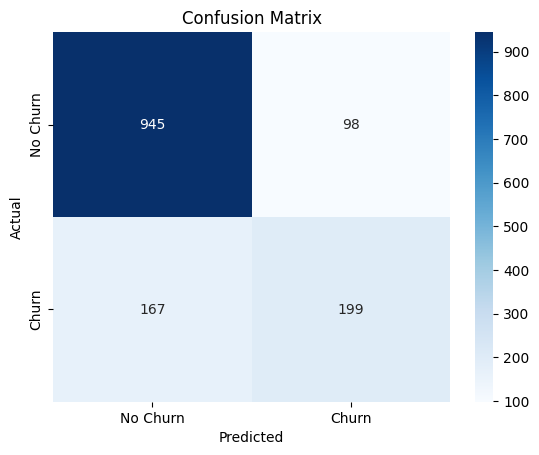

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Save the model
model.save_model("catboost_customer_churn_model.cbm")

# Load and use the model (example)
loaded_model = CatBoostClassifier()
loaded_model.load_model("catboost_customer_churn_model.cbm")
new_predictions = loaded_model.predict(X_test)
print("New Predictions:", new_predictions[:50])

New Predictions: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 1]
